# Faster R-CNN
Sprint16で読んだFaster R-CNN[1]の実装を動かします。

[1]Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99

https://arxiv.org/pdf/1506.01497.pdf

以下のものを使用してください。Kerasを使用した実装です。

duckrabbits/ObjectDetection at master

## 【問題1】学習と推定
READMEを参考に上記実装を動かしてください。
→動きました。

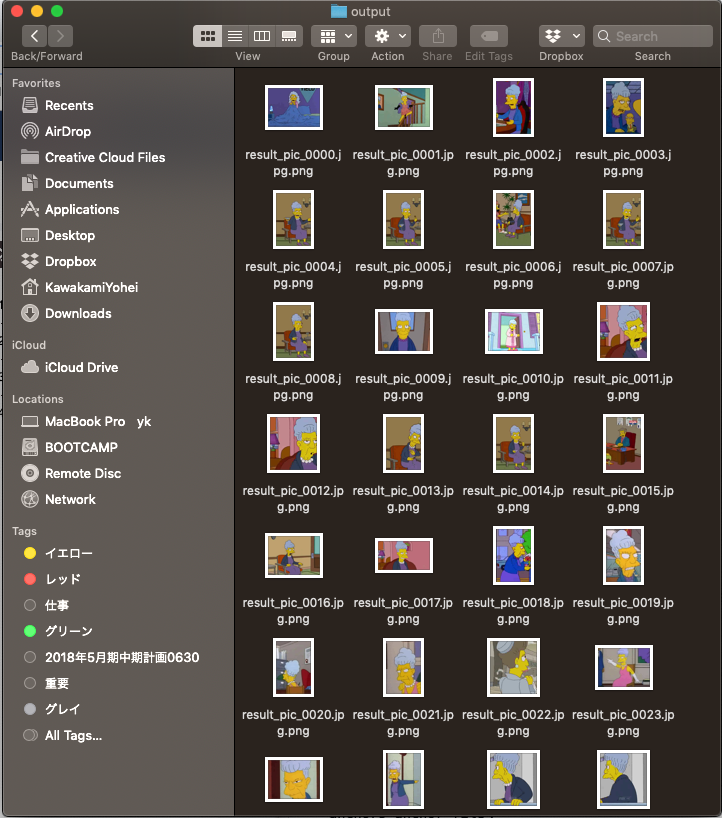

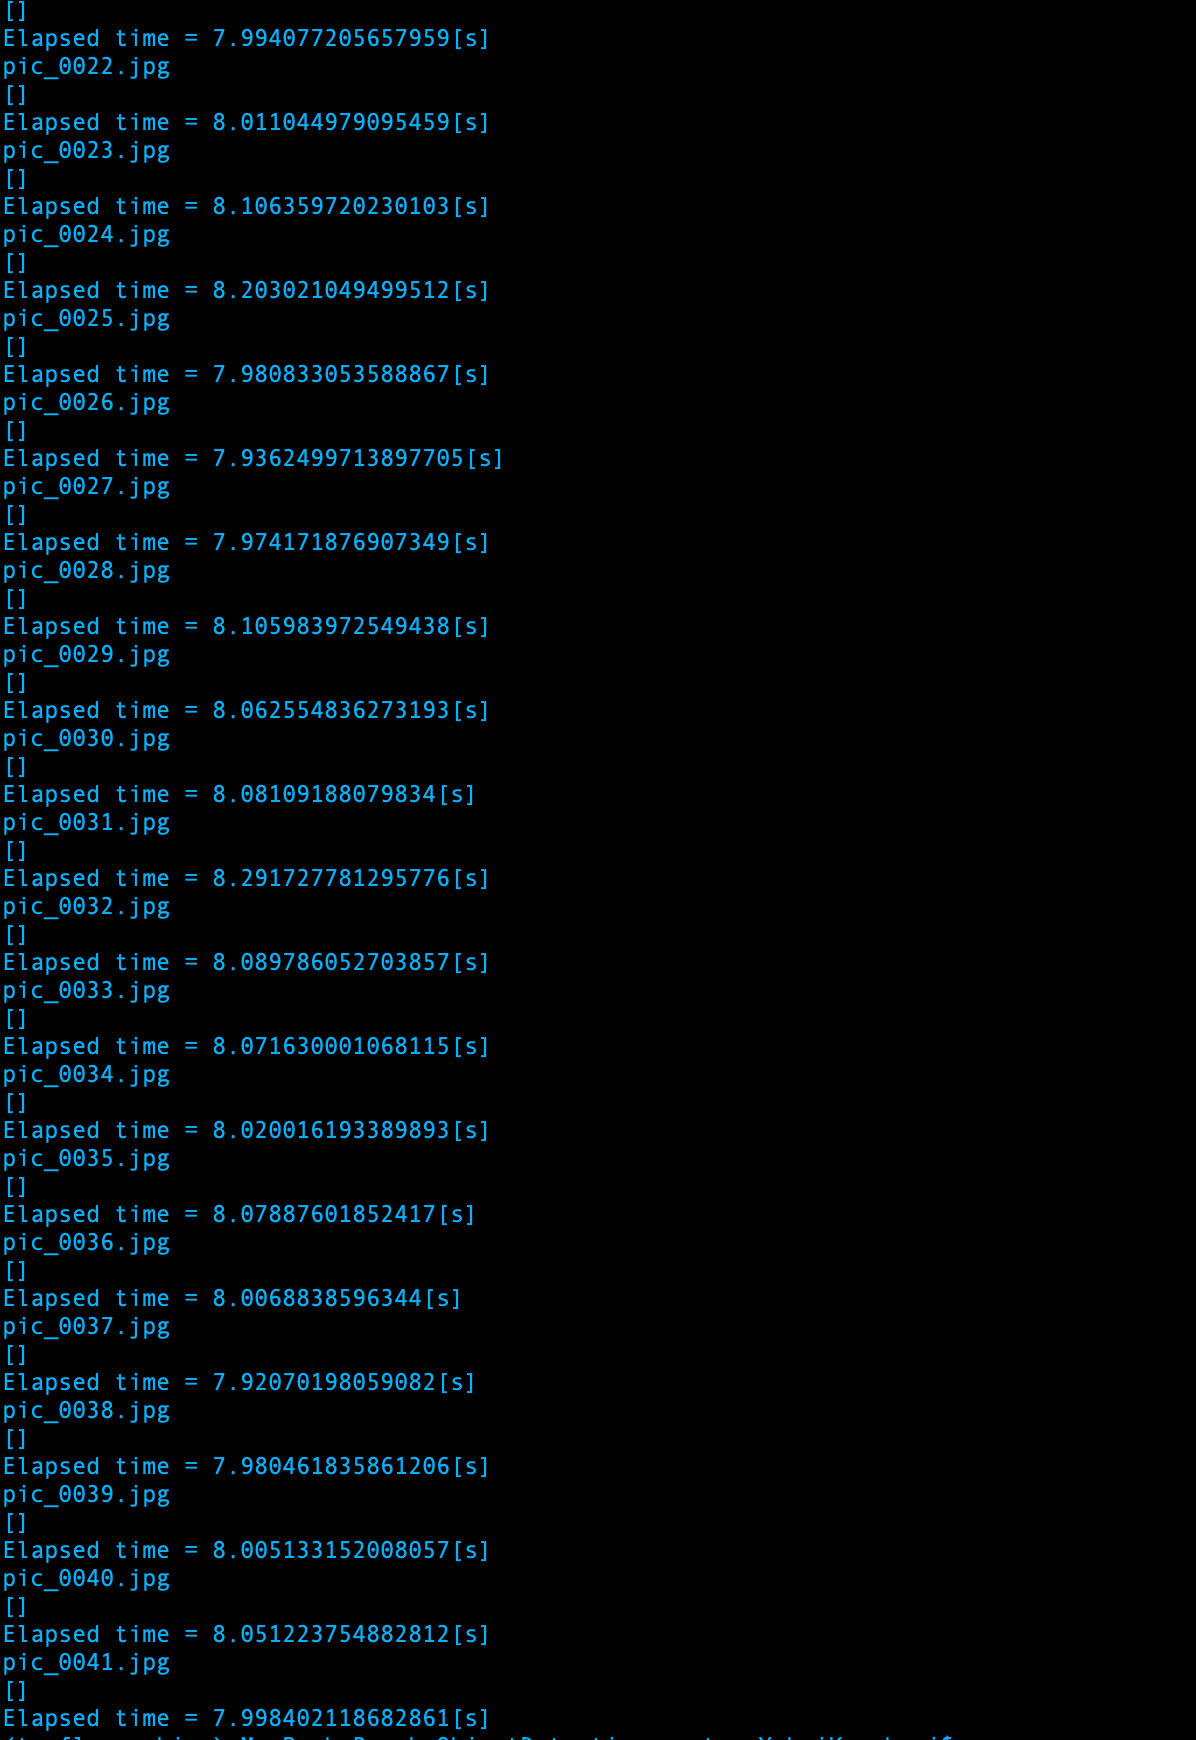

In [131]:
# plan
import os
import os.path
from IPython.display import display
from PIL import Image

path1 = "sim1.png"
path2 = "sim2.png"
display(Image.open(path1))
display(Image.open(path2))

## 【問題2】論文と実装の対応
コードリーディングを行ってください。

まず、Faster R-CNN[1]において重要だと考えた部分を列挙してください。そして、それに対応するコードを見つけてください。

（例）

RPNを実現しているコードはどこか
RoIプーリングを実現しているコードはどこか
フレームワークには畳み込み層など一般的なものはクラスが用意されていますが、RoIプーリングなど特定の手法限定のものは用意されていません。オリジナルのレイヤーを作成することが可能であり、Kerasであれば以下のページに情報がまとまっています。

オリジナルのKerasレイヤーを作成する - Keras Documentation

参考

KerasではVGG16のクラスが用意されているため、簡単に利用ができます。include_top=Falseの引数を与えることで、出力のための全結合層部分が除かれます。weights='imagenet'でImageNetを利用した学習済みモデルも手に入り、転移学習が行えます。weights='None'とすればランダムな初期化となります。

Applications - Keras Documentation

### ・RPNを実現しているコードはどこか

In [4]:
# faster_rcnn.py
def get_model(C, classes_count):
    img_input = Input(shape=(None, None, 3))
    roi_input = Input(shape=(C.num_rois, 4))

    # define the base network (resnet here)
    shared_layers = nn.nn_base(img_input, trainable=True)

    # define the RPN, built on the base layers
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
    rpn = nn.rpn(shared_layers, num_anchors)

    
# resnet.py
def rpn(base_layers,num_anchors):

    x = Convolution2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Convolution2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Convolution2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

### ・RoIプーリングを実現しているコードはどこか

In [2]:
# RoiPoolingConv.py: 
class RoiPoolingConv():
    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
            
            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'th':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)
                        
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)


## YOLOv3
シンプソンズのデータセットをFaster R-CNN以外の手法で学習・推定を行います。YOLOv3[2]のKeras実装を使います。

qqwweee/keras-yolo3: A Keras implementation of YOLOv3 (Tensorflow backend)

[2]Jeseph Redmon, Ali Farhadi. YOLOv3: An Incremental Improvement

https://pjreddie.com/media/files/papers/YOLOv3.pdf

Sprint18で使用した実装（再掲）

lasershow/SimpsonRecognition: Detect and recognize The Simpsons characters using Keras and Faster R-CNN

In [40]:
import pandas as pd

data = pd.read_table('annotation.txt', header=None)
data.head()

/anaconda/envs/tesflowmachine/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


,0
0,simpsons_dataset/abraham_grampa_simpson/pic_00...
1,simpsons_dataset/abraham_grampa_simpson/pic_00...
2,simpsons_dataset/abraham_grampa_simpson/pic_00...
3,simpsons_dataset/abraham_grampa_simpson/pic_00...
4,simpsons_dataset/abraham_grampa_simpson/pic_00...


In [41]:
base_data = data[0].str.split('/', expand=True)
base_data.head()

,0,1,2
0,simpsons_dataset,abraham_grampa_simpson,"pic_0000.jpg,57,72,52,72,abraham_grampa_simpson"
1,simpsons_dataset,abraham_grampa_simpson,"pic_0001.jpg,80,31,337,354,abraham_grampa_simpson"
2,simpsons_dataset,abraham_grampa_simpson,"pic_0002.jpg,128,48,285,407,abraham_grampa_sim..."
3,simpsons_dataset,abraham_grampa_simpson,"pic_0003.jpg,72,126,158,275,abraham_grampa_sim..."
4,simpsons_dataset,abraham_grampa_simpson,"pic_0004.jpg,123,61,294,416,abraham_grampa_sim..."


In [105]:
split_url = base_data[2].str.split(',', expand=True)
class_simpsons = split_url[5].unique()

In [106]:
for i, simpson in enumerate(class_simpsons):
    split_url.replace(simpson, str(i), inplace=True)

In [107]:
split_url

,0,1,2,3,4,5
0,pic_0000.jpg,57,72,52,72,0
1,pic_0001.jpg,80,31,337,354,0
2,pic_0002.jpg,128,48,285,407,0
3,pic_0003.jpg,72,126,158,275,0
4,pic_0004.jpg,123,61,294,416,0
5,pic_0005.jpg,115,18,498,413,0
6,pic_0006.jpg,171,47,423,413,0
7,pic_0007.jpg,120,53,381,409,0
8,pic_0008.jpg,149,56,398,406,0
9,pic_0009.jpg,205,41,470,456,0


In [122]:
conbine_data = base_data[0] + '/' + base_data[1] + '/' + split_url[0] + ' ' + split_url[1] + ',' + split_url[2] + ',' + split_url[3] + ',' + split_url[4] + ',' + split_url[5] 

In [123]:
# import numpy as np
# np.set_printoptions(threshold=100)
conbine_data.values

array(['simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg 57,72,52,72,0',
       'simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg 80,31,337,354,0',
       'simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg 128,48,285,407,0',
       ..., 'simpsons_dataset/moe_szyslak/pic_0337.jpg 66,75,196,245,13',
       'simpsons_dataset/moe_szyslak/pic_1067.jpg 159,44,287,247,13',
       'simpsons_dataset/moe_szyslak/pic_0928.jpg 185,64,396,329,13'],
      dtype=object)

In [124]:
conbine_data.to_csv("conbine_data.txt", encoding="shift_jis", index=None, sep='"')

/anaconda/envs/tesflowmachine/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## 【問題3】学習済みの重みによる推定
学習済みの重みを使い推定を行う方法がREADME.mdのQuick Startに記載されています。

まずはこの通りにして各自何かしらの画像や動画に対して検出を行ってください。

出力結果を課題の一部として提出してください。



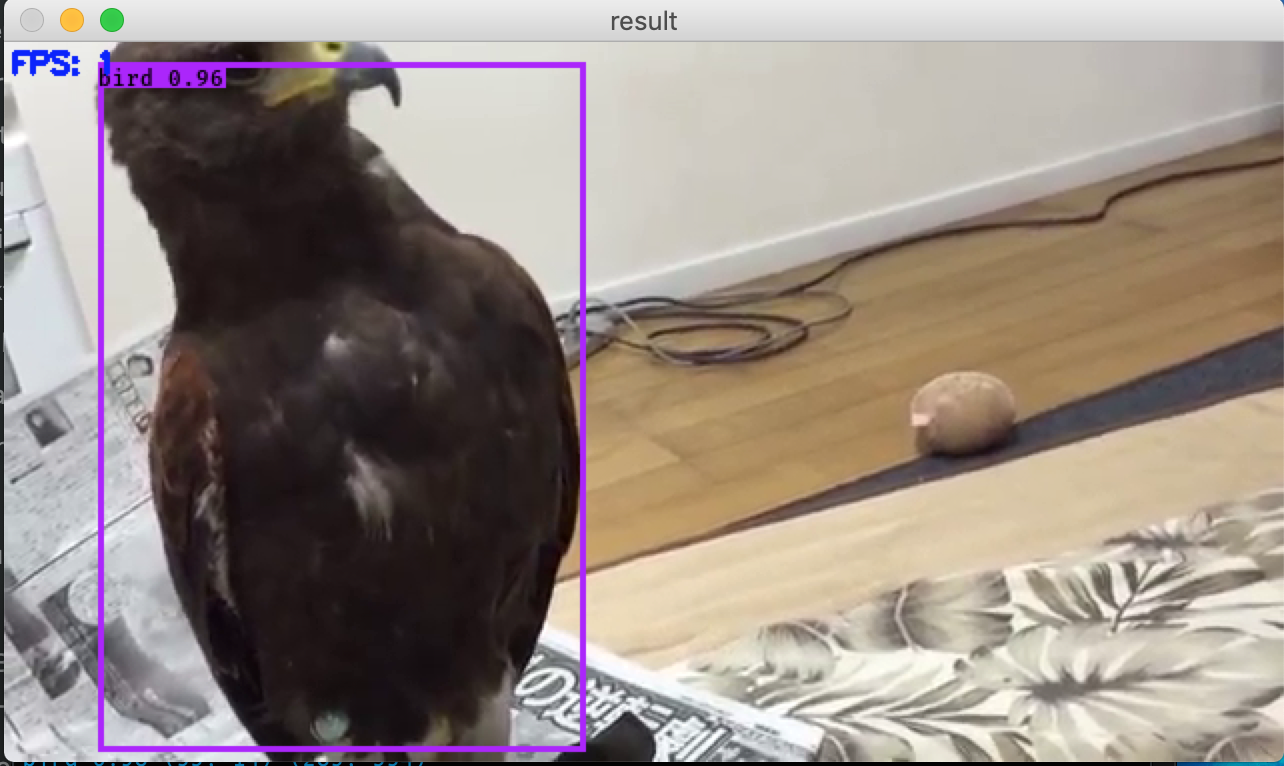

In [132]:
# plan
import os
import os.path
from IPython.display import display
from PIL import Image

path1 = "YOLO.png"
# path2 = "sim2.png"
display(Image.open(path1))
# display(Image.open(path2))

## 【問題4】学習のためのファイルを作成
新しいデータ（シンプソンズデータセット）を学習します。README.mdのTrainingを読み、シンプソンズデータセットを学習するために必要なファイルを作成してください。

アノテーションファイルの形式がSprint18で扱った実装のものとは異なっているので、変換する必要があります。

## 【問題5】学習
問題2で作成したファイルを使用して学習してください。実行環境で学習に時間がかかる場合は、学習が行えることを確認するのみで終えて構いません。

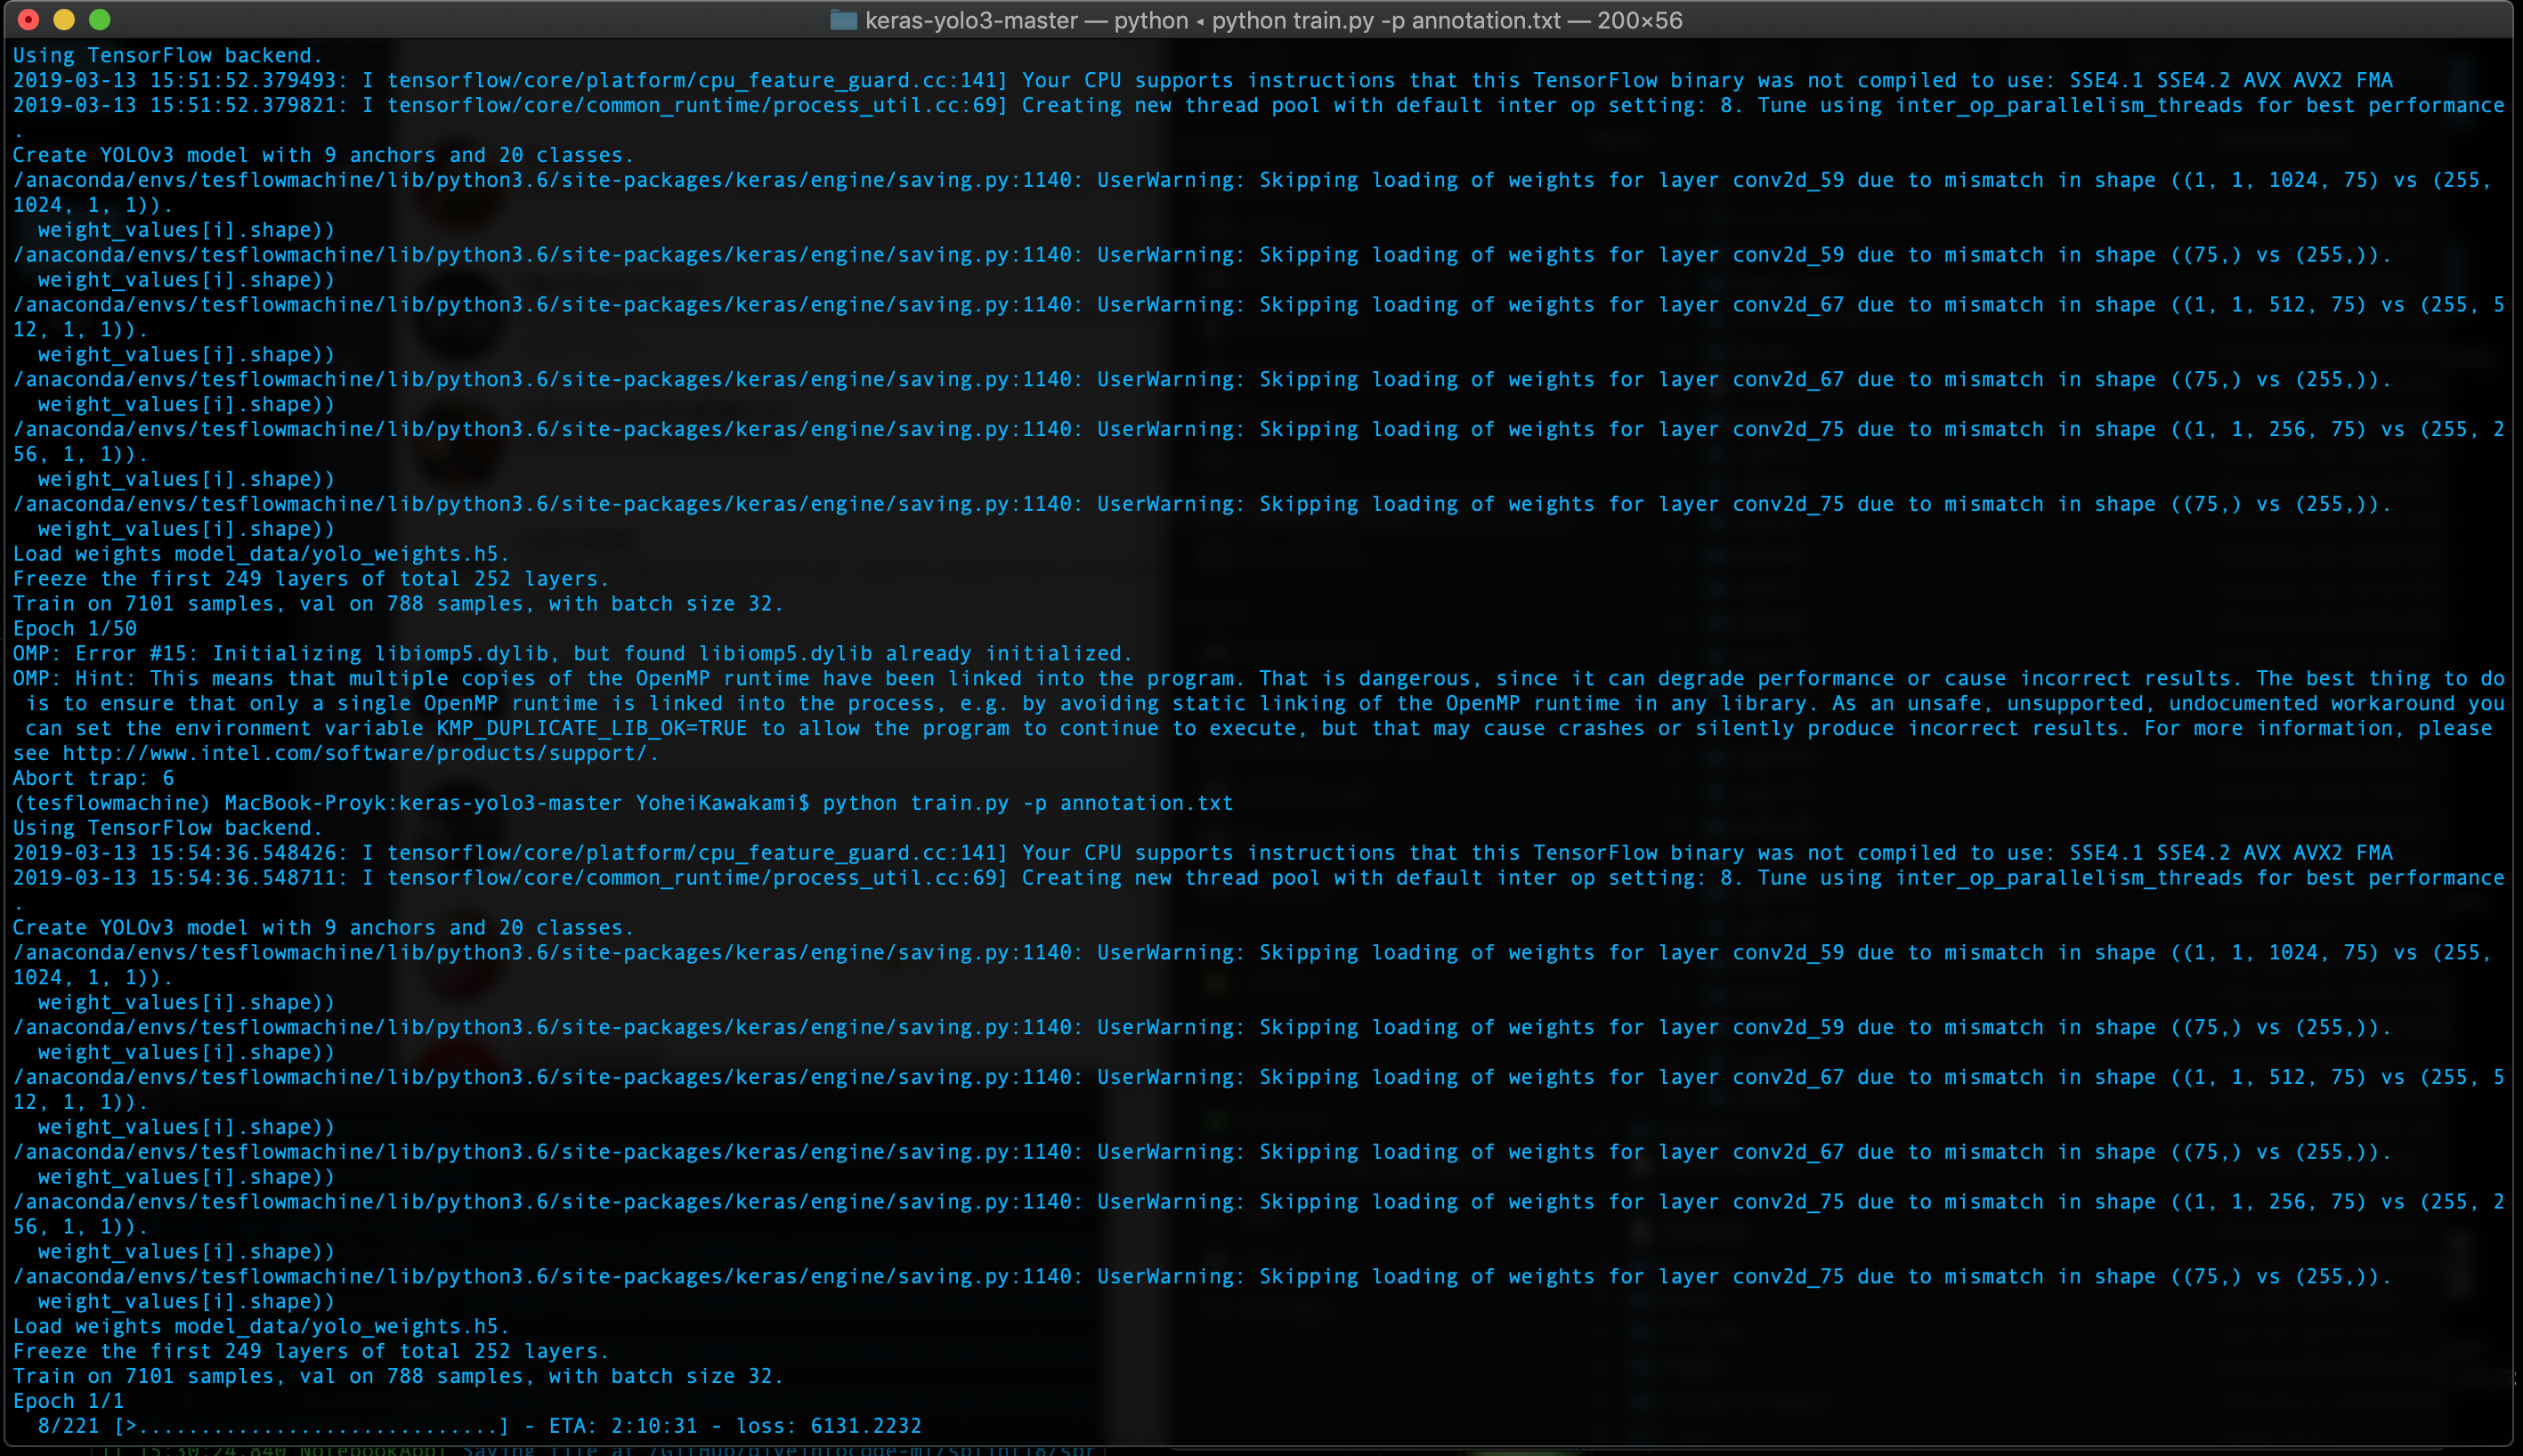

In [133]:
# plan
import os
import os.path
from IPython.display import display
from PIL import Image

path1 = "YOLO2.png"
# path2 = "sim2.png"
display(Image.open(path1))
# display(Image.open(path2))

## 【問題6】（アドバンス課題）論文と実装の対応
コードリーディングを行ってください。

まず、YOLOv3[2]の論文において重要だと考えた部分を列挙してください。そして、それに対応するコードを見つけてください。

# Githubでの提出
検証や説明を行ったファイルをsprint18-run-implementation.ipynbとしてsprint18に格納